In [15]:
import torch
import torchvision

In [6]:
train_ds = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor()
)
test_ds = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor()
)

In [7]:
batch_size=64
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, num_workers=2
)

In [8]:
for X, y in train_loader:
    print(X.shape, y.shape)
    break

torch.Size([64, 3, 32, 32]) torch.Size([64])


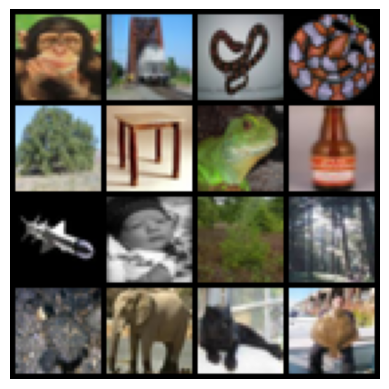

In [14]:
from torchvision.utils import make_grid

grid = make_grid(X[:16], nrow=4).permute(1, 2, 0).numpy()
plt.imshow(grid)
plt.axis('off')
plt.show()